In [1]:
%load_ext autoreload
%autoreload 2

#First test the pump flow control. Seems ok with I = 0.02

In [ ]:
from datetime import datetime, timedelta
import random
from control.modules.thrusters import ThrustersControl, ThrustersParameters
from input_output.base import Stamped
from input_output.definitions.simulation import Boundary, Pcs, TemperatureBoundary, Thruster
from input_output.modules.thrusters import ThrustersSensorValues, ThrustersSimulationInputs, ThrustersSimulationOutputs
from orchestration.collector import PolarsCollector
from orchestration.executor import SimulationExecutor
from simulation.fmu import Fmu
from simulation.io_mapping import IoMapping
from simulation.models.fmu_paths import thrusters_path


simulation_inputs = ThrustersSimulationInputs(
        thrusters_aft=Thruster(
            heat_flow=Stamped.stamp(9000), active=Stamped.stamp(True)
        ),
        thrusters_fwd=Thruster(
            heat_flow=Stamped.stamp(4300), active=Stamped.stamp(True)
        ),
        thrusters_seawater_supply=Boundary(
            temperature=Stamped.stamp(32), flow=Stamped.stamp(1)
        ),
        thrusters_module_supply=TemperatureBoundary(temperature=Stamped.stamp(50)),
        thrusters_pcs=Pcs(mode=Stamped.stamp("propulsion")),
    )



In [ ]:
control = ThrustersControl(
    ThrustersParameters(
        recovery_mix_target_temperature=40, recovery_flow_target_temperature=60
    )
)


executor = SimulationExecutor(
    IoMapping(
        Fmu(thrusters_path),
        ThrustersSensorValues,
        ThrustersSimulationOutputs,
    ),
    simulation_inputs,
    datetime.now(),
    timedelta(seconds=1),
)


result_collector = PolarsCollector()


control.to_recovery(ThrustersSensorValues.zero())
control._current_values.thrusters_mix_aft.setpoint = Stamped(
    value=1.0, timestamp=control._time
)

control._current_values.thrusters_mix_fwd.setpoint = Stamped(
    value=1.0, timestamp=control._time
)

result = await executor.tick(control._current_values)


pump_setpoints = []
for i in range(1000):
    control._time = executor.time()

    if i % 30 == 0:
        control._pump_flow_controller.setpoint = random.randint(0, 40)

    pump_setpoints.append(control._pump_flow_controller.setpoint)

    control._active_pump.dutypoint = Stamped(
        value=control._pump_flow_controller(
            result.sensor_values.thrusters_flow_aft.flow.value
            + result.sensor_values.thrusters_flow_fwd.flow.value,
            control._time,
        ),
        timestamp=control._time,
    )

    result = await executor.tick(control._current_values)
    result_collector.collect(result.raw, control.mode, executor.time())

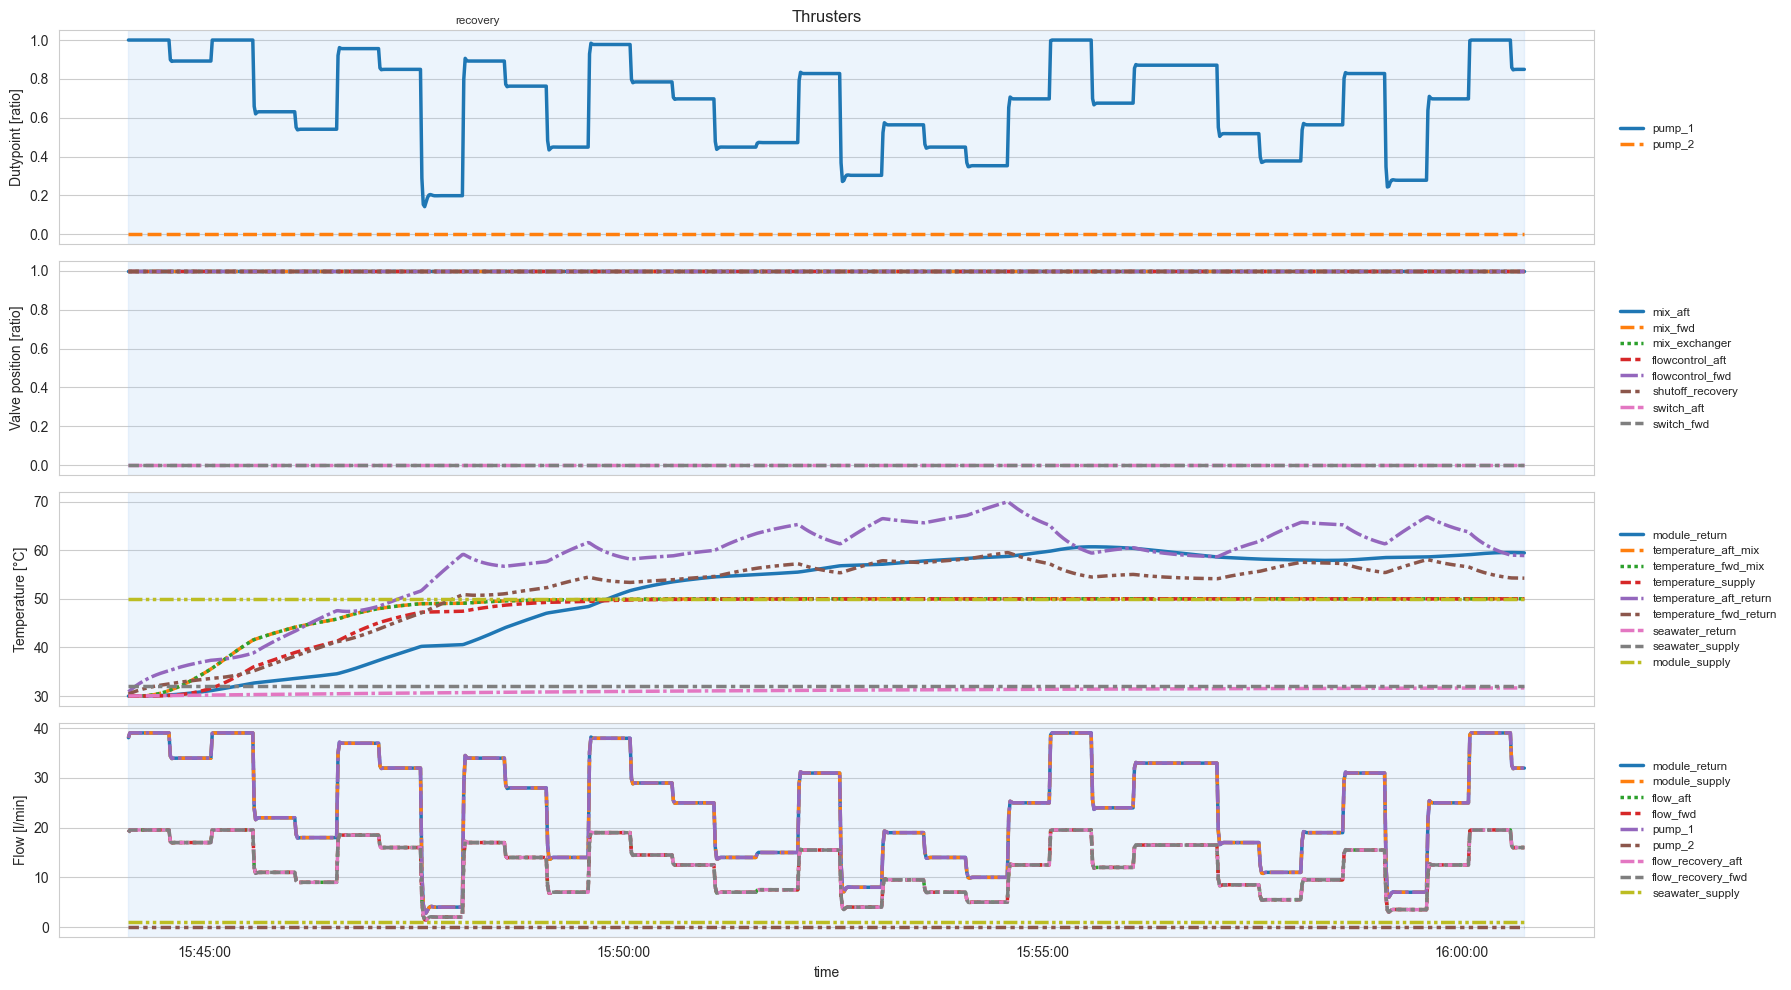

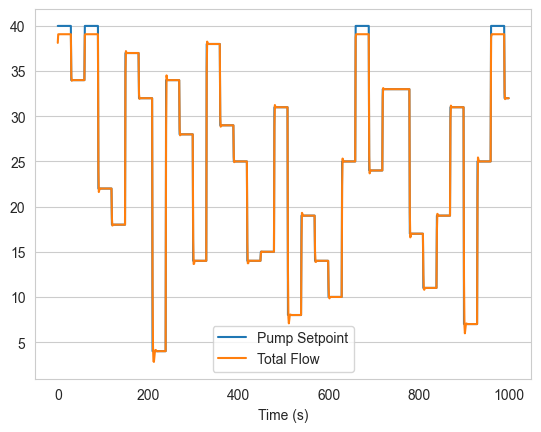

In [254]:
from analysis.analysis_utils import plot_result
from matplotlib import pyplot as plt

plot_result(result_collector.result(), 'plots/flowbasedtemp.png')

plt.figure()
plt.plot(pump_setpoints, label='Pump Setpoint')
plt.plot(result_collector.result()['thrusters_flow_aft__flow__l_min'] + result_collector.result()['thrusters_flow_fwd__flow__l_min'], label='Total Flow')
plt.xlabel('Time (s)')
plt.legend()

## Now look into flow balancing. This is more challenging and result are not so good. Some observations: 
- valves react very slow, in particular relative to pump 
- especially when the order switches (aft want more than fwd when it was different before), then due to the offset strategy we use in the flow control, it can take a long time to reach the desired position since valve must de fully open for other to be able to close.. 
- maybe better result when flow balancing is done by ratio
- maybe better results when pump doesnt strive for total flow but rather minimize sum of error on fwd and aft 
- what about pressure build up in the system due to this control (e.g. if pump and valves are out of sync?)


In [ ]:
async def test_flow_balance(flow_control_tuning: tuple[float, float, float]):
    control = ThrustersControl(
        ThrustersParameters(
            recovery_mix_target_temperature=40, recovery_flow_target_temperature=60
        )
    )


    executor = SimulationExecutor(
        IoMapping(
            Fmu(thrusters_path),
            ThrustersSensorValues,
            ThrustersSimulationOutputs,
        ),
        simulation_inputs,
        datetime.now(),
        timedelta(seconds=1),
    )


    result_collector = PolarsCollector()


    control.to_recovery(ThrustersSensorValues.zero())
    control._current_values.thrusters_mix_aft.setpoint = Stamped(
        value=1.0, timestamp=control._time
    )

    control._current_values.thrusters_mix_fwd.setpoint = Stamped(
        value=1.0, timestamp=control._time
    )

    result = await executor.tick(control._current_values)

    fwd_flow_setpoints = []
    aft_flow_setpoints = []
    control._flow_balance_controller.set_actives([True, True])
    for controller in control._flow_balance_controller._controllers:
        controller.tuning = flow_control_tuning

    random.seed(9001)
    for i in range(1000):
        control._time = executor.time()

        if i % 180 == 0:
            fwd_flow_setpoint = random.randint(0, 20)
            aft_flow_setpoint = random.randint(0, 20)
            control._flow_balance_controller.set_setpoints([
                aft_flow_setpoint,
                fwd_flow_setpoint,
            ])
        fwd_flow_setpoints.append(fwd_flow_setpoint)
        aft_flow_setpoints.append(aft_flow_setpoint)

        control._flow_balance_controller.set_setpoints([
            aft_flow_setpoint,
            fwd_flow_setpoint,
        ])
        control._pump_flow_controller.setpoint = aft_flow_setpoint + fwd_flow_setpoint

        control._active_pump.dutypoint = Stamped(
            value=control._pump_flow_controller(
                result.sensor_values.thrusters_flow_aft.flow.value
                + result.sensor_values.thrusters_flow_fwd.flow.value,
                control._time,
            ),
            timestamp=control._time,
        )

        control._flow_balance_controller(
            [
                result.sensor_values.thrusters_flow_aft.flow.value,
                result.sensor_values.thrusters_flow_fwd.flow.value,
            ],
            control._time,
        )

        result = await executor.tick(control._current_values)
        result_collector.collect(result.raw, control.mode, executor.time())

    return flow_control_tuning, aft_flow_setpoints, fwd_flow_setpoints, result_collector.result()['thrusters_flow_aft__flow__l_min'].to_list(), result_collector.result()['thrusters_flow_fwd__flow__l_min'].to_list(), result_collector.result()['thrusters_flowcontrol_aft__setpoint__ratio'].to_list(), result_collector.result()['thrusters_flowcontrol_fwd__setpoint__ratio'].to_list(), result_collector.result()['thrusters_flowcontrol_aft__position_rel__ratio'].to_list(), result_collector.result()['thrusters_flowcontrol_fwd__position_rel__ratio'].to_list()


In [278]:
tunings = [
    (0.00, 0.01, 0),
    (0.00, 0.005, 0),
    (0.01, 0.005, 0),
    (0.01, 0.005, 0.001),
]

results = [await test_flow_balance(tuning) for tuning in tunings]

/var/folders/w7/x3ddjmps2dvfqdrygwzccnd00000gn/T/ipykernel_25209/1205070623.py:8: RuntimeWarning: coroutine 'test_flow_balance' was never awaited
  results = [await test_flow_balance(tuning) for tuning in tunings]


In [276]:
def plot_flow_test(results: list):
    fig, axes = plt.subplots(
        3, len(results), figsize=(5 * len(results), 10), sharex=True
    )
    for i, result in enumerate(results):
        (
            flow_control_tuning,
            aft_flow_setpoints,
            fwd_flow_setpoints,
            aft_flow,
            fwd_flow,
            aft_valve_setpoint,
            fwd_valve_setpoint,
            aft_valve_position,
            fwd_valve_position,
        ) = result
        axes[0, i].plot(fwd_flow_setpoints, "--", label="Fwd flow setpoint")
        axes[0, i].plot(aft_flow_setpoints, "--", label="Aft flow setpoint")
        axes[0, i].plot(aft_flow, label="Aft flow")
        axes[0, i].plot(fwd_flow, label="Fwd flow")

        axes[0, i].legend(loc="upper left", bbox_to_anchor=(1, 1))
        axes[0, i].set_title(f"{flow_control_tuning}")

        # total_error = sum(abs(aft_setpoint - aft_flow) + abs(fwd_setpoint - fwd_flow) for aft_setpoint, aft_flow, fwd_setpoint, fwd_flow in zip(aft_flow, fwd_flow, aft_flow_setpoints, fwd_flow_setpoints))

        # axes[0,i].text(1.02, 0.55, f'Total error: {total_error:.2f}', transform=axes[0,i].transAxes, fontsize=10, verticalalignment='top')
        axes[1, i].plot(aft_valve_setpoint, "--", label="Aft valve setpoint")
        axes[1, i].plot(fwd_valve_setpoint, "--", label="Fwd valve setpoint")
        axes[1, i].plot(aft_valve_position, label="Aft valve position")
        axes[1, i].plot(fwd_valve_position, label="Fwd valve position")
        axes[1, i].legend(loc="upper left", bbox_to_anchor=(1, 1))

        axes[2, i].plot(
            [sum(x) for x in zip(aft_flow_setpoints, fwd_flow_setpoints)],
            "--",
            label="Total flow setpoint",
        )
        axes[2, i].plot([sum(x) for x in zip(aft_flow, fwd_flow)], label="Total flow")
        axes[2, i].legend(loc="upper left", bbox_to_anchor=(1, 1))

        axes[-1, i].set_xlabel("Time (s)")

        plt.tight_layout()


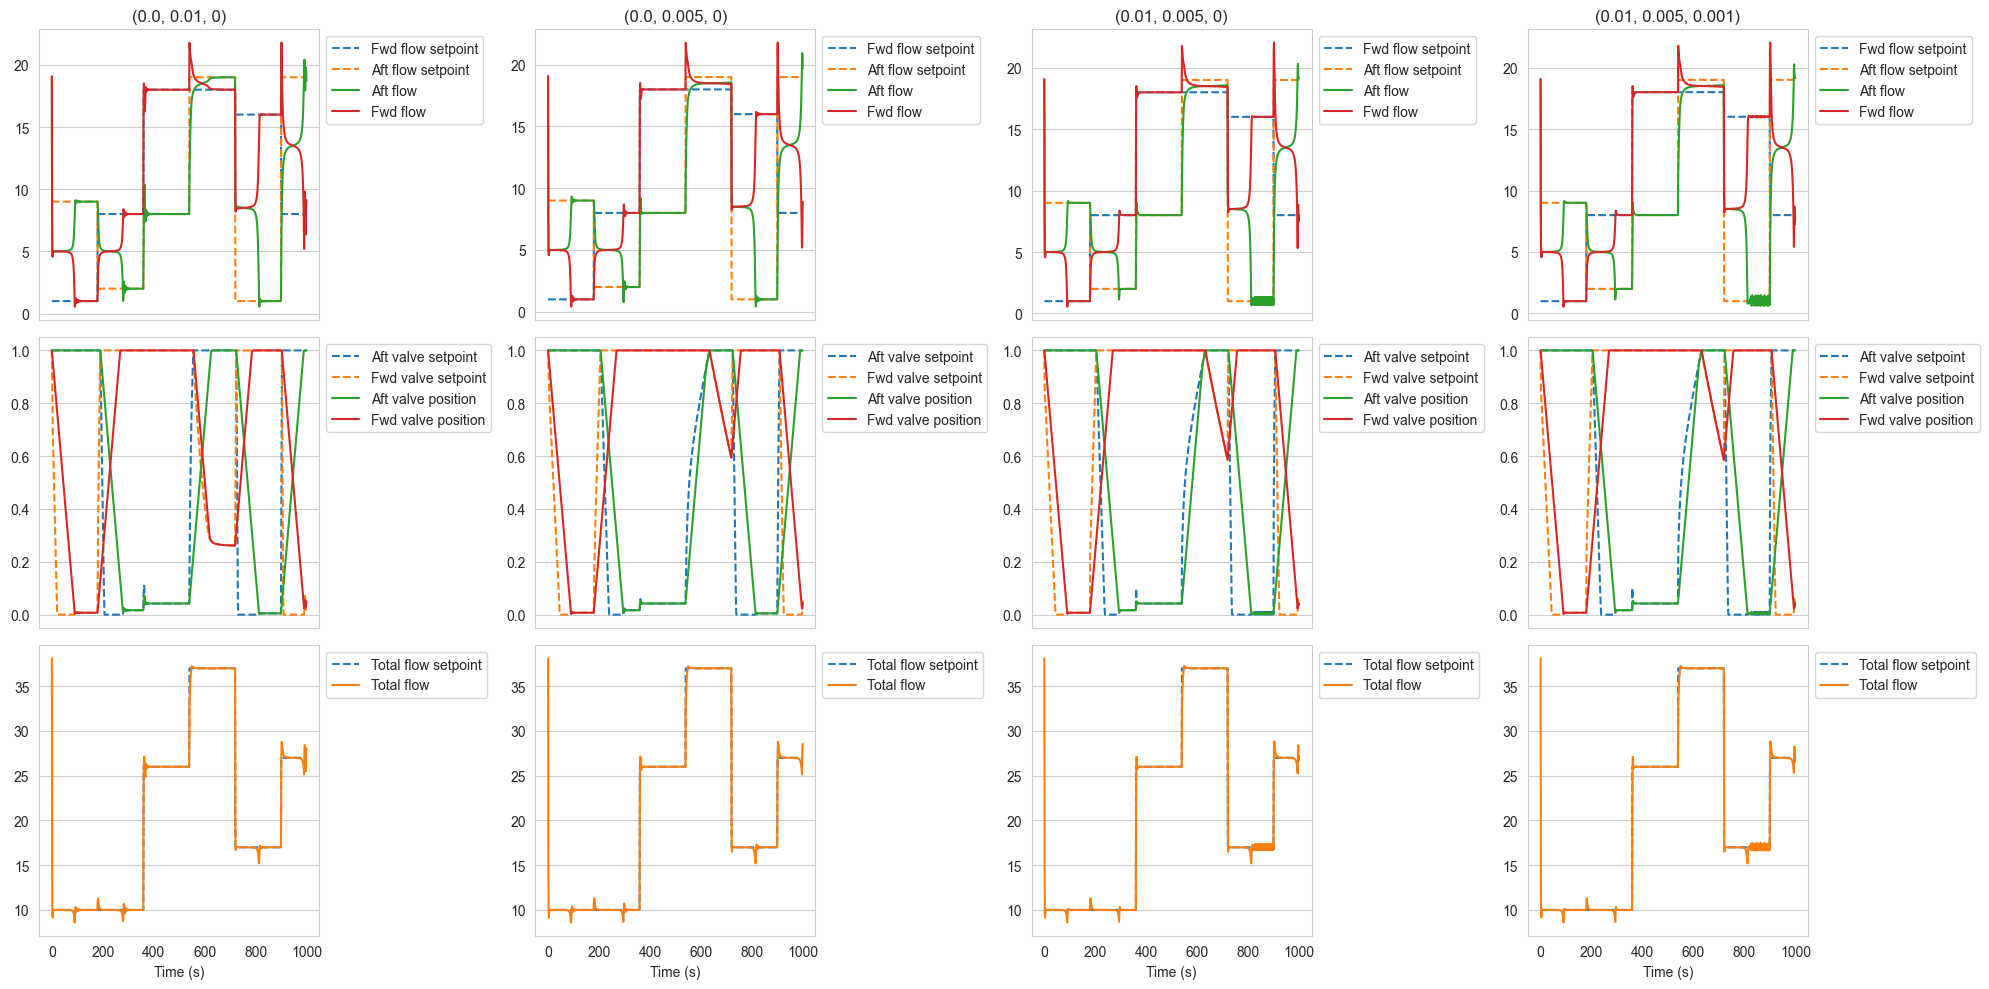

In [262]:
plot_flow_test(results)


## Now test the temperature control that should determine the flow setpoints

- ignore mixing valves at first...

- plot the results of the flow based temp control (setpt and real flow...)
- want to combine into single controller?
- ...


In [272]:
async def test_temperature_control(flow_control_tuning: tuple[float, float, float]):
    control = ThrustersControl(
        ThrustersParameters(
            recovery_mix_target_temperature=40, recovery_flow_target_temperature=60
        )
    )

    executor = SimulationExecutor(
        IoMapping(
            Fmu(thrusters_path),
            ThrustersSensorValues,
            ThrustersSimulationOutputs,
        ),
        simulation_inputs,
        datetime.now(),
        timedelta(seconds=1),
    )

    result_collector = PolarsCollector()

    control.to_recovery(ThrustersSensorValues.zero())
    control._current_values.thrusters_mix_aft.setpoint = Stamped(
        value=1.0, timestamp=control._time
    )

    control._current_values.thrusters_mix_fwd.setpoint = Stamped(
        value=1.0, timestamp=control._time
    )

    result = await executor.tick(control._current_values)

    fwd_flow_setpoints = []
    aft_flow_setpoints = []
    control._flow_balance_controller.set_actives([True, True])
    for controller in control._flow_balance_controller._controllers:
        controller.tuning = flow_control_tuning

    for i in range(1000):
        control._time = executor.time()

        aft_flow_setpoint = control._aft_recovery_flow_controller(
            result.sensor_values.thrusters_temperature_aft_mix.temperature.value,
            executor.time(),
        )
        fwd_flow_setpoint = control._fwd_recovery_flow_controller(
            result.sensor_values.thrusters_temperature_fwd_mix.temperature.value,
            executor.time(),
        )
        control._flow_balance_controller.set_setpoints([
            aft_flow_setpoint,
            fwd_flow_setpoint,
        ])
        fwd_flow_setpoints.append(fwd_flow_setpoint)
        aft_flow_setpoints.append(aft_flow_setpoint)

        control._flow_balance_controller.set_setpoints([
            aft_flow_setpoint,
            fwd_flow_setpoint,
        ])
        control._pump_flow_controller.setpoint = aft_flow_setpoint + fwd_flow_setpoint

        control._active_pump.dutypoint = Stamped(
            value=control._pump_flow_controller(
                result.sensor_values.thrusters_flow_aft.flow.value
                + result.sensor_values.thrusters_flow_fwd.flow.value,
                control._time,
            ),
            timestamp=control._time,
        )

        control._flow_balance_controller(
            [
                result.sensor_values.thrusters_flow_aft.flow.value,
                result.sensor_values.thrusters_flow_fwd.flow.value,
            ],
            control._time,
        )

        result = await executor.tick(control._current_values)
        result_collector.collect(result.raw, control.mode, executor.time())

    plot_result(result_collector.result(), "plots/test.png")

    return (
        flow_control_tuning,
        aft_flow_setpoints,
        fwd_flow_setpoints,
        result_collector.result()["thrusters_flow_aft__flow__l_min"].to_list(),
        result_collector.result()["thrusters_flow_fwd__flow__l_min"].to_list(),
        result_collector.result()[
            "thrusters_flowcontrol_aft__setpoint__ratio"
        ].to_list(),
        result_collector.result()[
            "thrusters_flowcontrol_fwd__setpoint__ratio"
        ].to_list(),
        result_collector.result()[
            "thrusters_flowcontrol_aft__position_rel__ratio"
        ].to_list(),
        result_collector.result()[
            "thrusters_flowcontrol_fwd__position_rel__ratio"
        ].to_list(),
    )


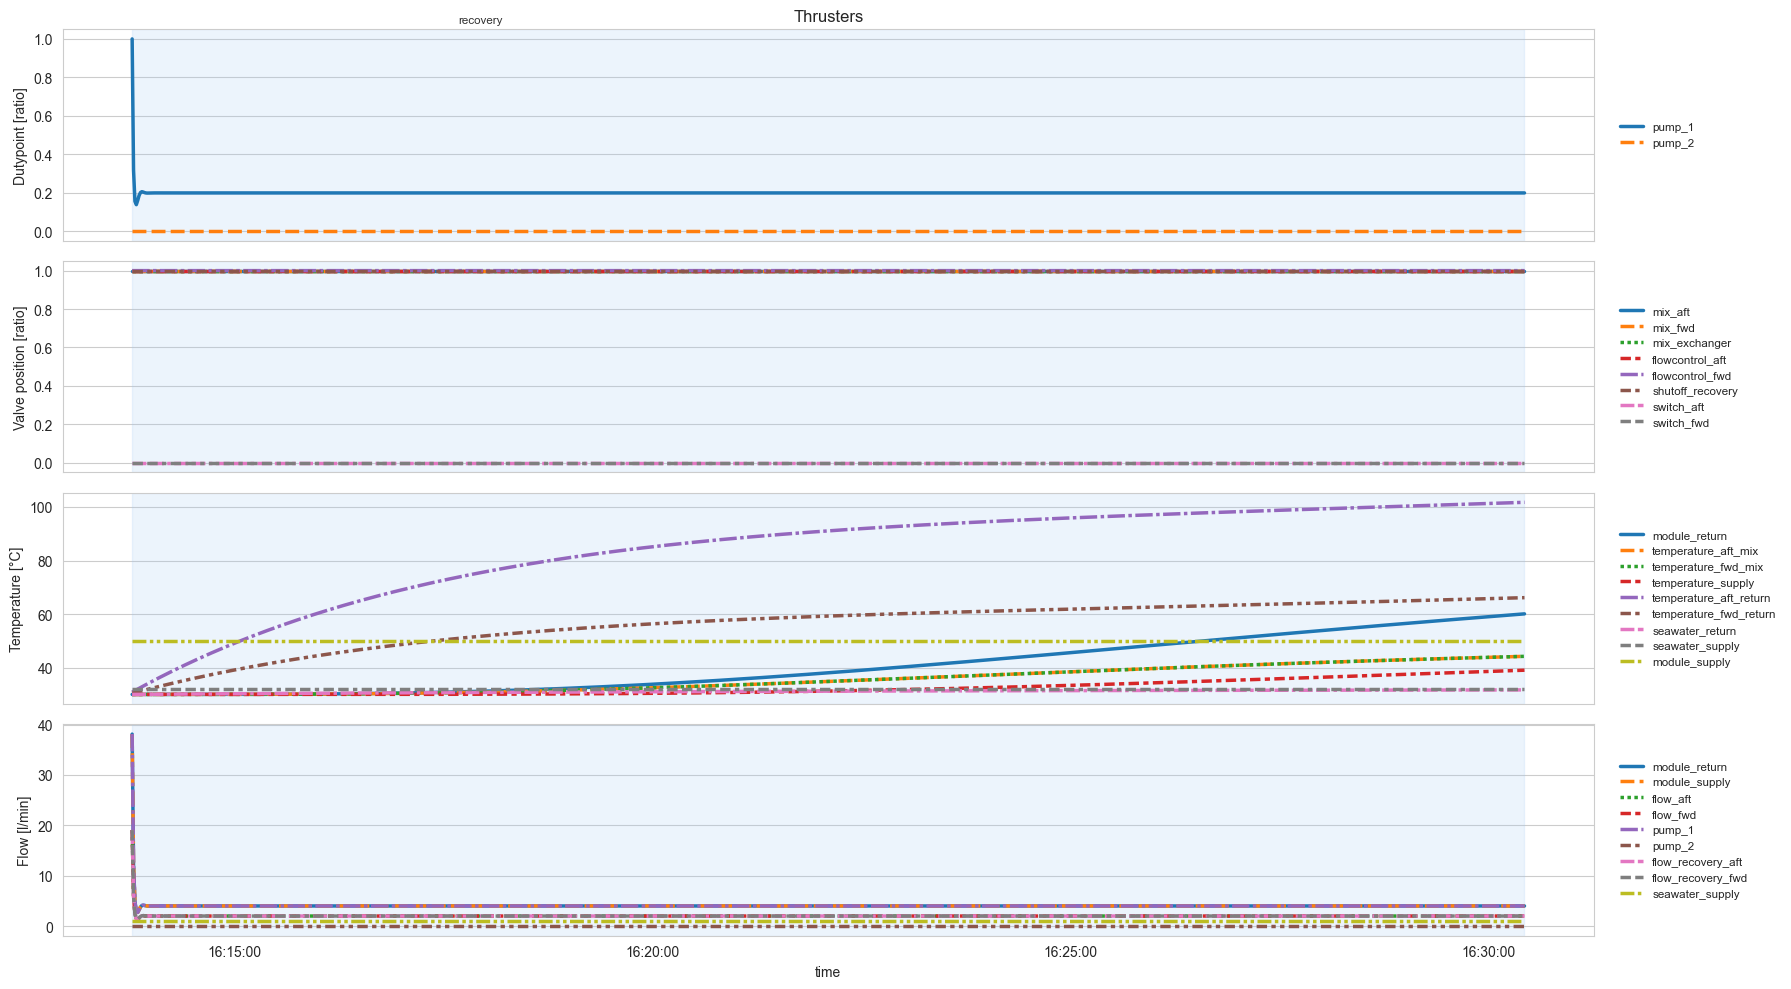

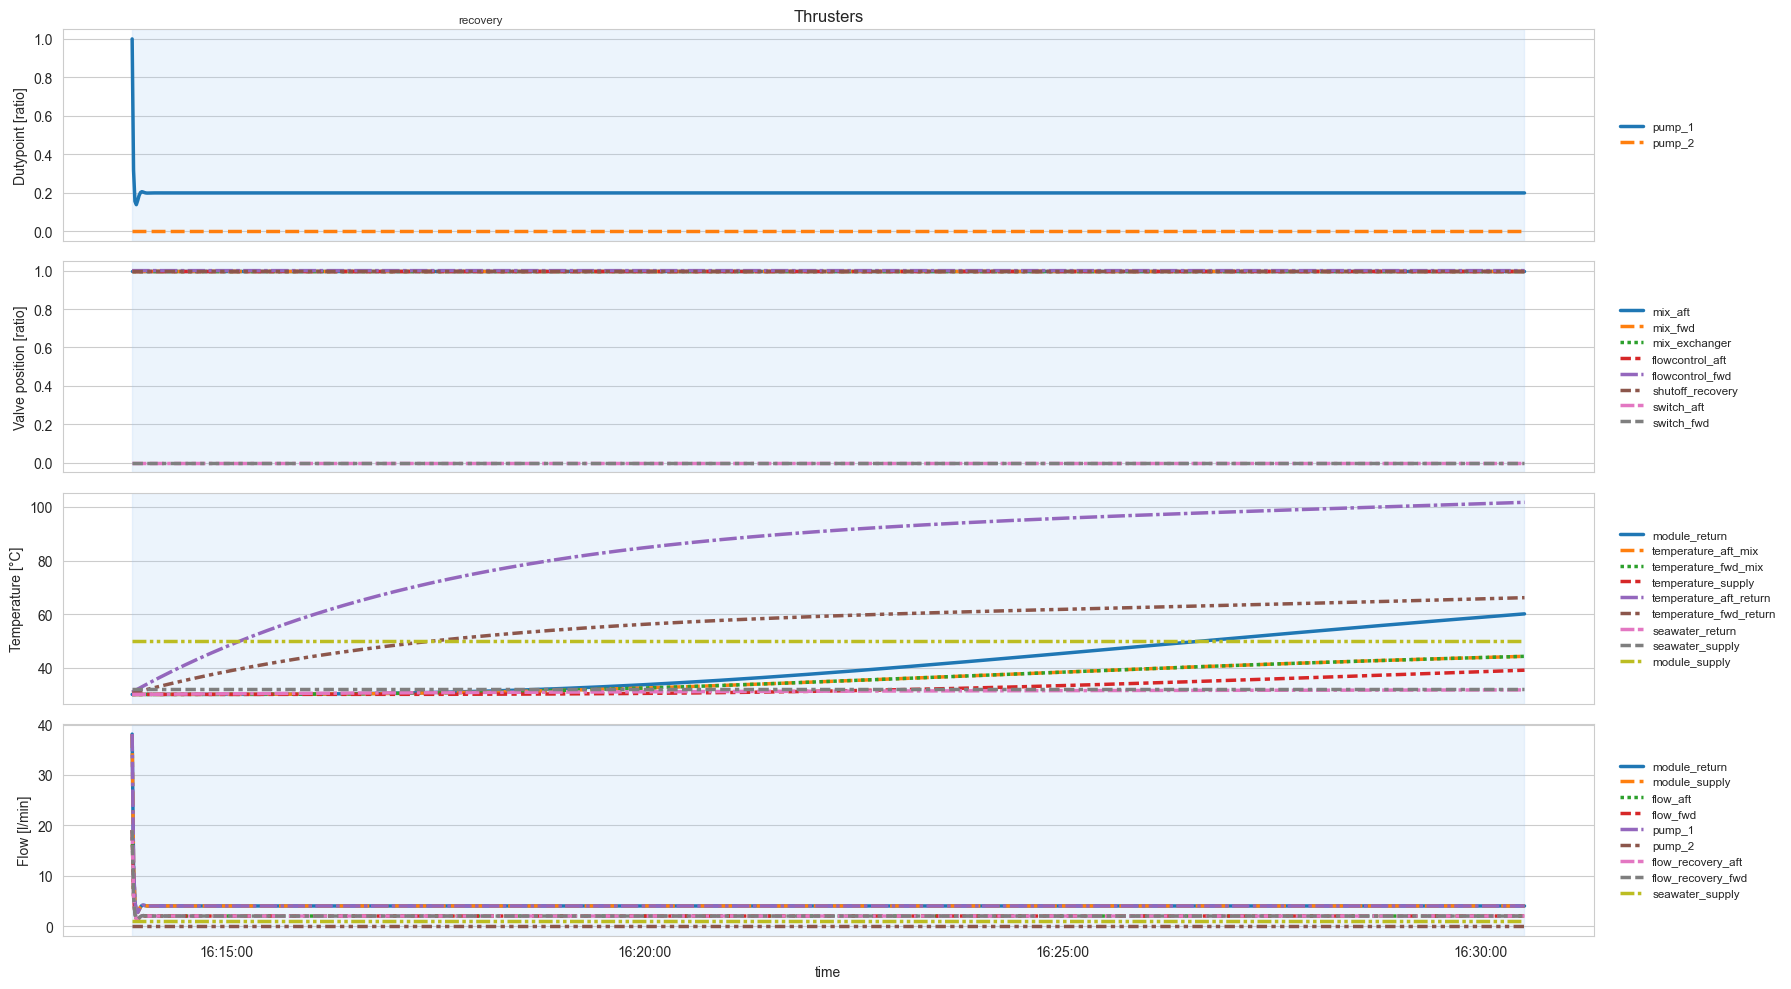

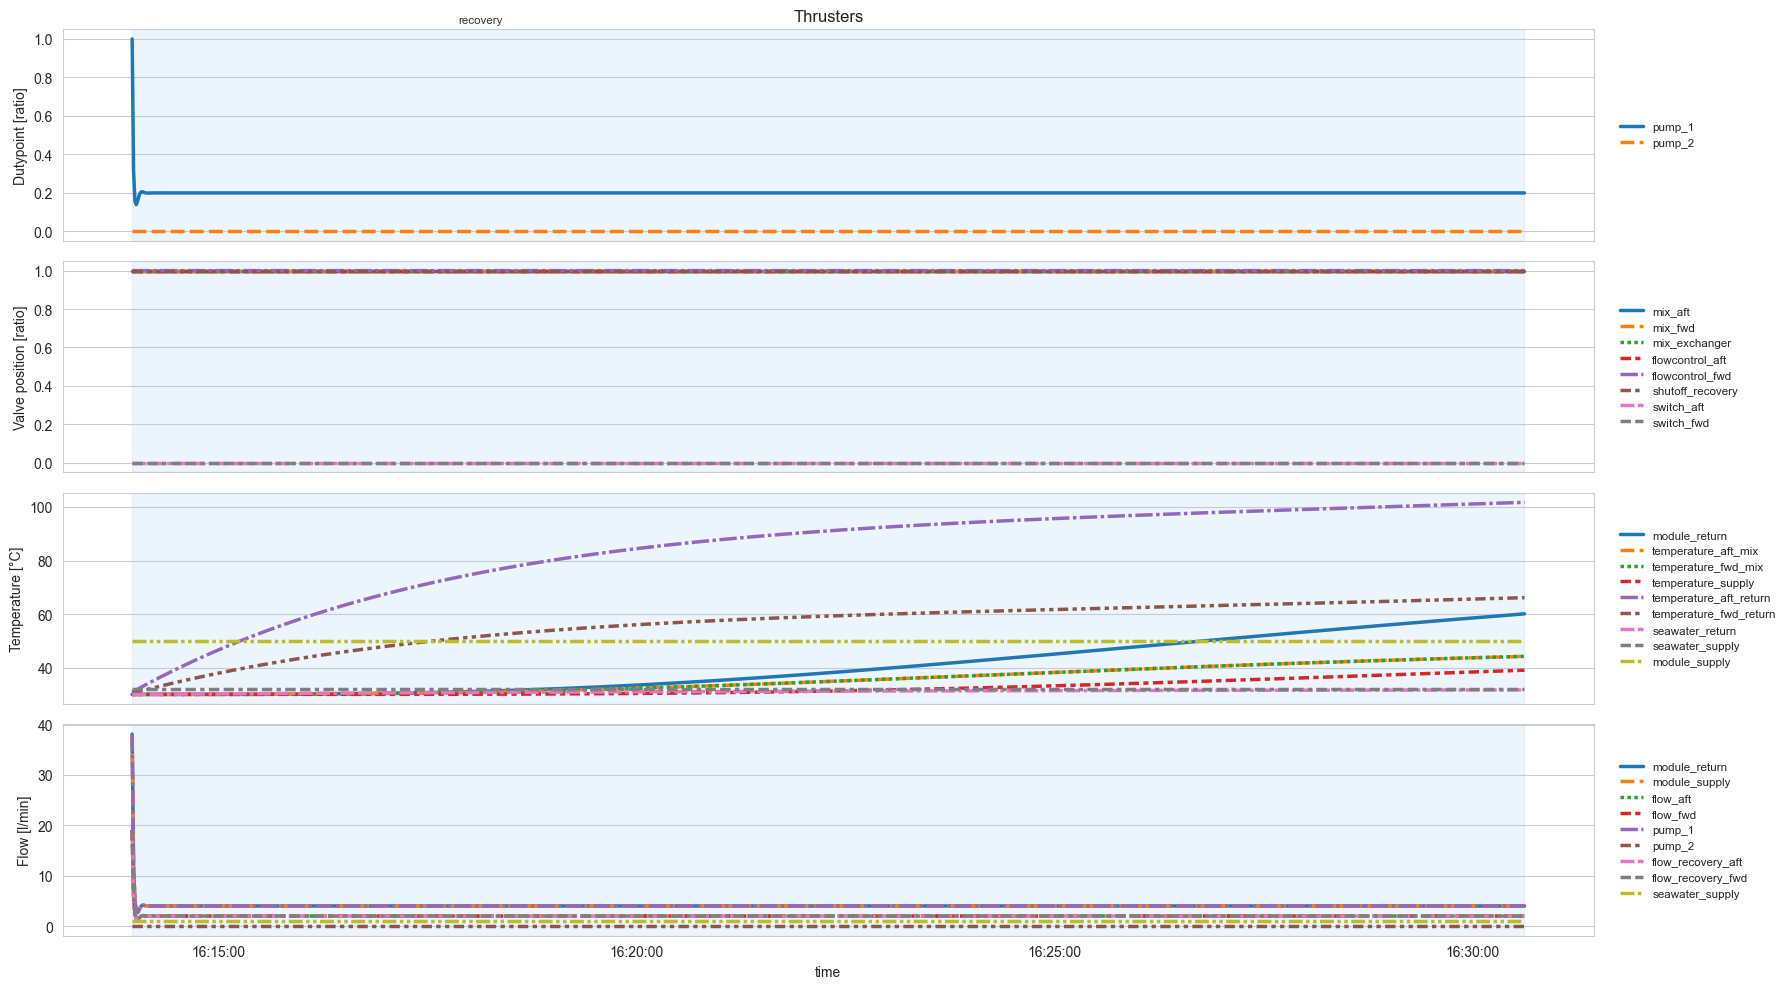

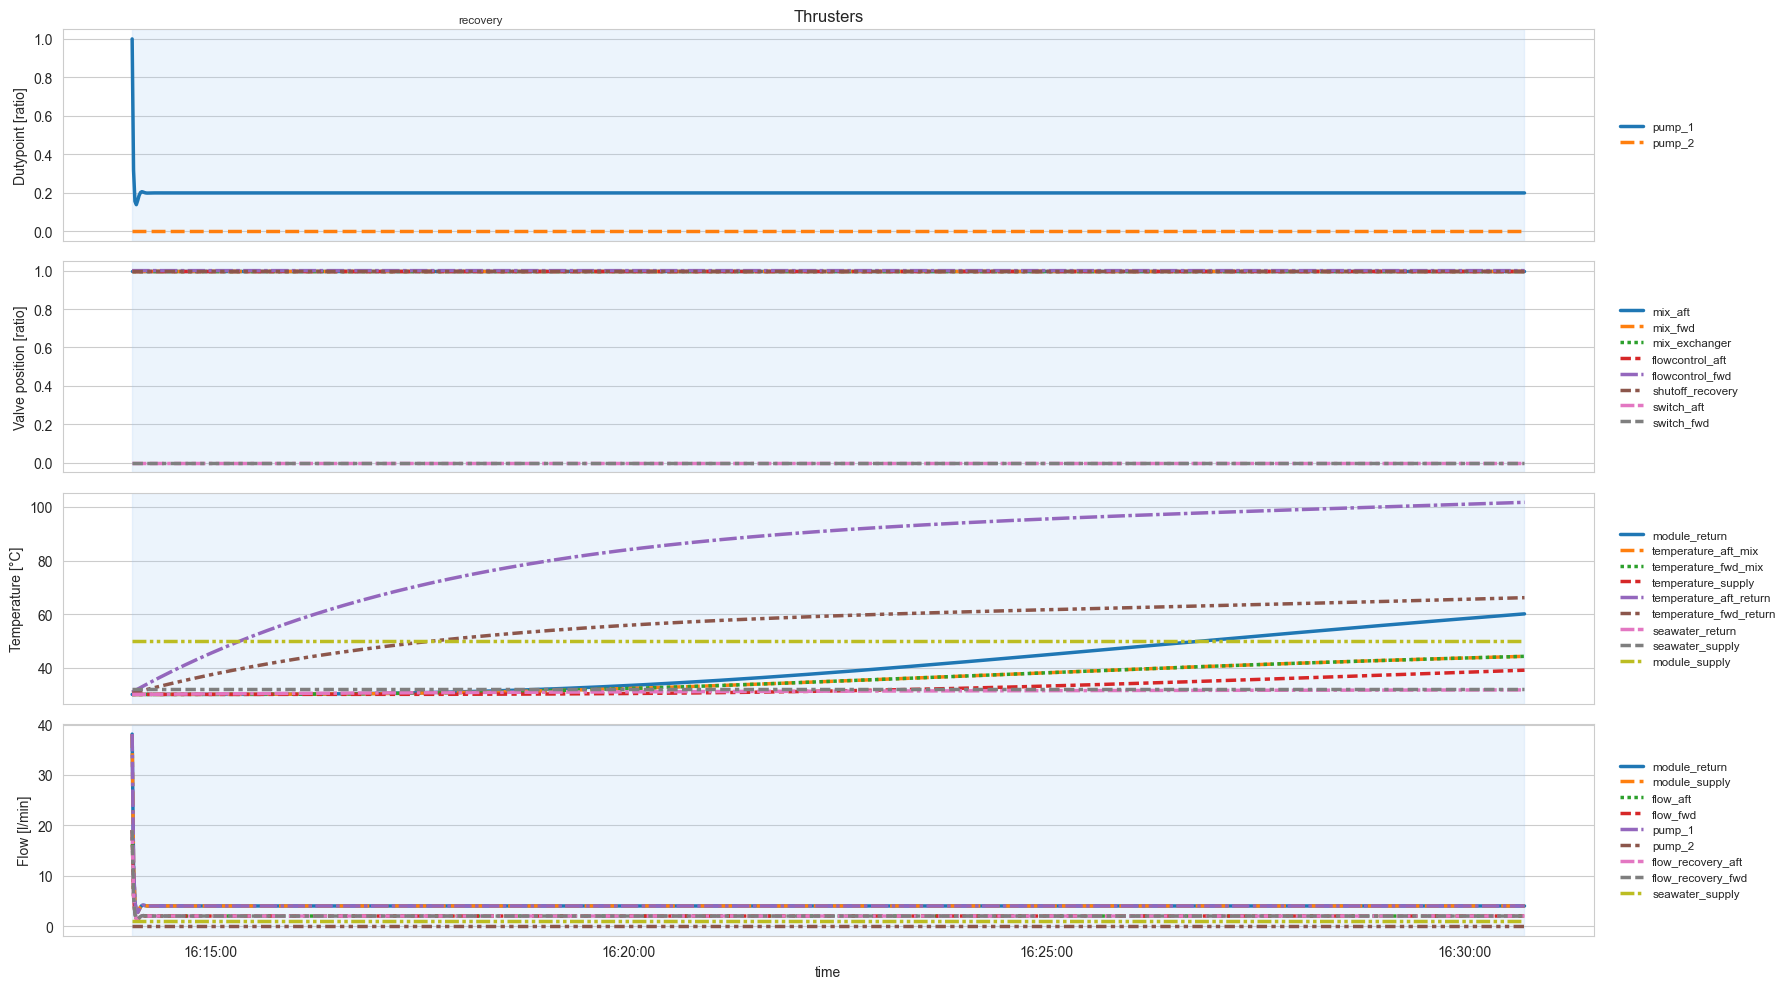

In [273]:
tunings = [
    (0.00, 0.01, 0),
    (0.00, 0.005, 0),
    (0.01, 0.005, 0),
    (0.01, 0.005, 0.001),
]

results = [await test_temperature_control(tuning) for tuning in tunings]

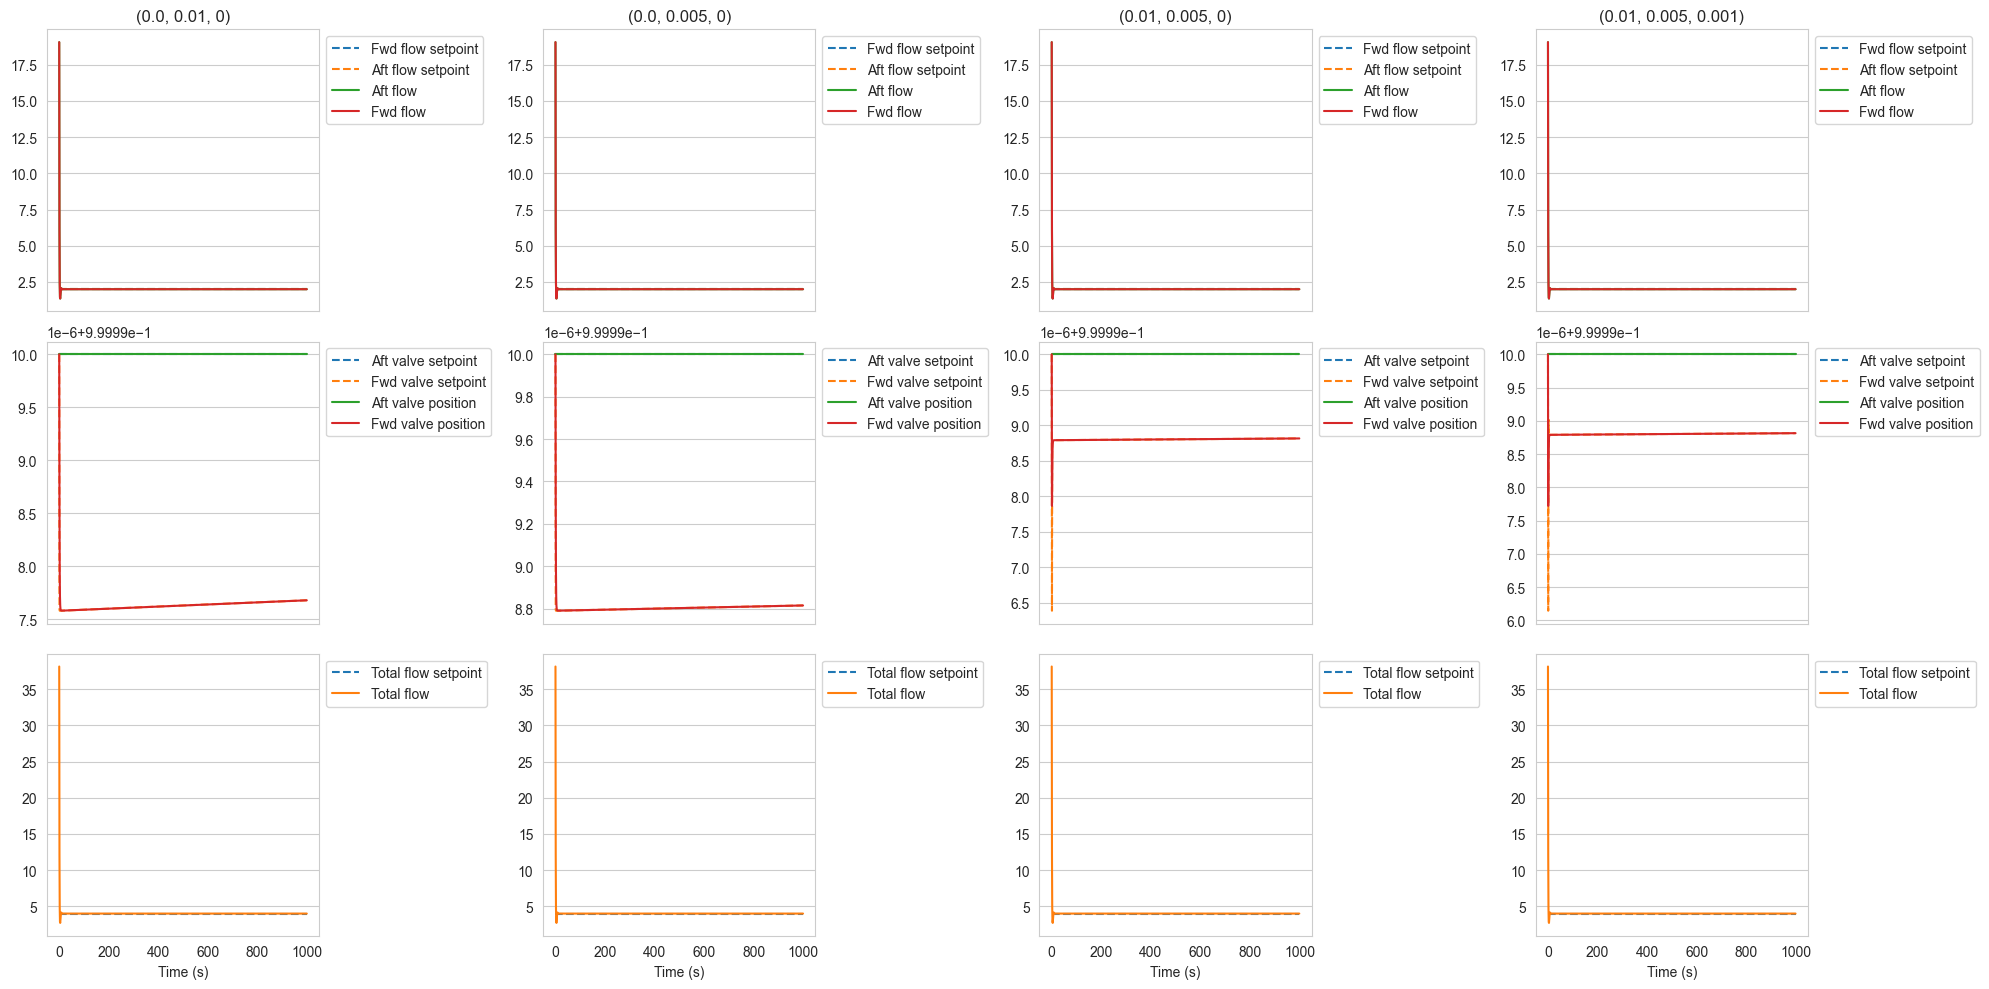

In [ ]:
plot_flow_test(results)


((0.0, 0.01, 0),
 [2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2